In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd

from tqdm.notebook import tqdm, trange

If you want the result to be reproducible, you will need to set the seed.

In [ ]:
# SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

Mount to Google drive and unpack your dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Unpack the dataset zip file
# shutil.unpack_archive("/content/drive/MyDrive/MMU/Deep Learning/Assessment/archive.zip", "/content/Datasets/")

In [ ]:
len(datasets.ImageFolder('/content/Datasets/Train')), len(datasets.ImageFolder('/content/Datasets/Validation'))

834036

Taking subset from Training and Validation set

In [ ]:
# Creating a smaller dataset, from the original one to reduce execution time, and saving it to the /content/Datasets/ directory of colab.

for folder in os.listdir('/content/Datasets/Train'):
  if not os.path.exists('/content/Datasets/sample_datast/Train/'+folder):
    os.makedirs('/content/Datasets/sample_datast/Train/'+folder)
    for file in os.listdir('/content/Datasets/Train/'+folder)[:100]:
      shutil.copy('/content/Datasets/Train/'+folder+'/'+file, '/content/Datasets/sample_datast/Train/'+folder+'/')

for folder in os.listdir('/content/Datasets/Validation'):
  if not os.path.exists('/content/Datasets/sample_datast/Validation/'+folder):
    os.makedirs('/content/Datasets/sample_datast/Validation/'+folder)
    for file in os.listdir('/content/Datasets/Validation/'+folder)[:30]:
      shutil.copy('/content/Datasets/Validation/'+folder+'/'+file, '/content/Datasets/sample_datast/Validation/'+folder+'/')

print('Sample dataset created with 100 images each for every character for Train set and 30 images each for validation set')

In [ ]:
# Creating a test set of images for prediction and saving it to the /content/Datasets directory.
if not os.path.exists('/content/Datasets/sample_datast/Test'):
  os.makedirs('/content/Datasets/sample_datast/Test')
else:
  shutil.rmtree('/content/Datasets/sample_datast/Test')

for folder in os.listdir('/content/Datasets/Train'):
  os.makedirs('/content/Datasets/sample_datast/Test/'+folder)
  for file in os.listdir('/content/Datasets/Train/'+folder)[105:106]:
    shutil.copy('/content/Datasets/Train/'+folder+'/'+file, '/content/Datasets/sample_datast/Test/'+folder+'/')

print('Training sample created successfully')

Training sample created successfully


Image resizing and image augmentation

In [ ]:
batch_size = 32
transform_train = transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    transforms.Resize((32,32)),
    #torchvision.transforms.RandomResizedCrop(32, scale=(0.08, 1.0),
    #                                         ratio=(3.0/4.0, 4.0/3.0)),
    #torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    #torchvision.transforms.ColorJitter(brightness=0.4,
    #                                   contrast=0.4,
    #                                   saturation=0.4),
    # Add random noise
    transforms.ToTensor(),
    # Standardize each channel of the image
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    # Crop a 224 x 224 square area from the center of the image
    #torchvision.transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

Reading the dataset

In [ ]:
data_dir = '/content/Datasets/sample_datast/'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['Train', 'Train']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['Validation', 'Test']]

In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

This is an additional code to check the mean and standard deviation of your dataset - you can then use it to replace the values in transforms.Normalize to improve your work.


In [ ]:
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([-1.3053, -1.2050, -0.9774])
Calculated stds: tensor([1.5182, 1.5521, 1.5452])


Show image - display some of your images for observation.

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

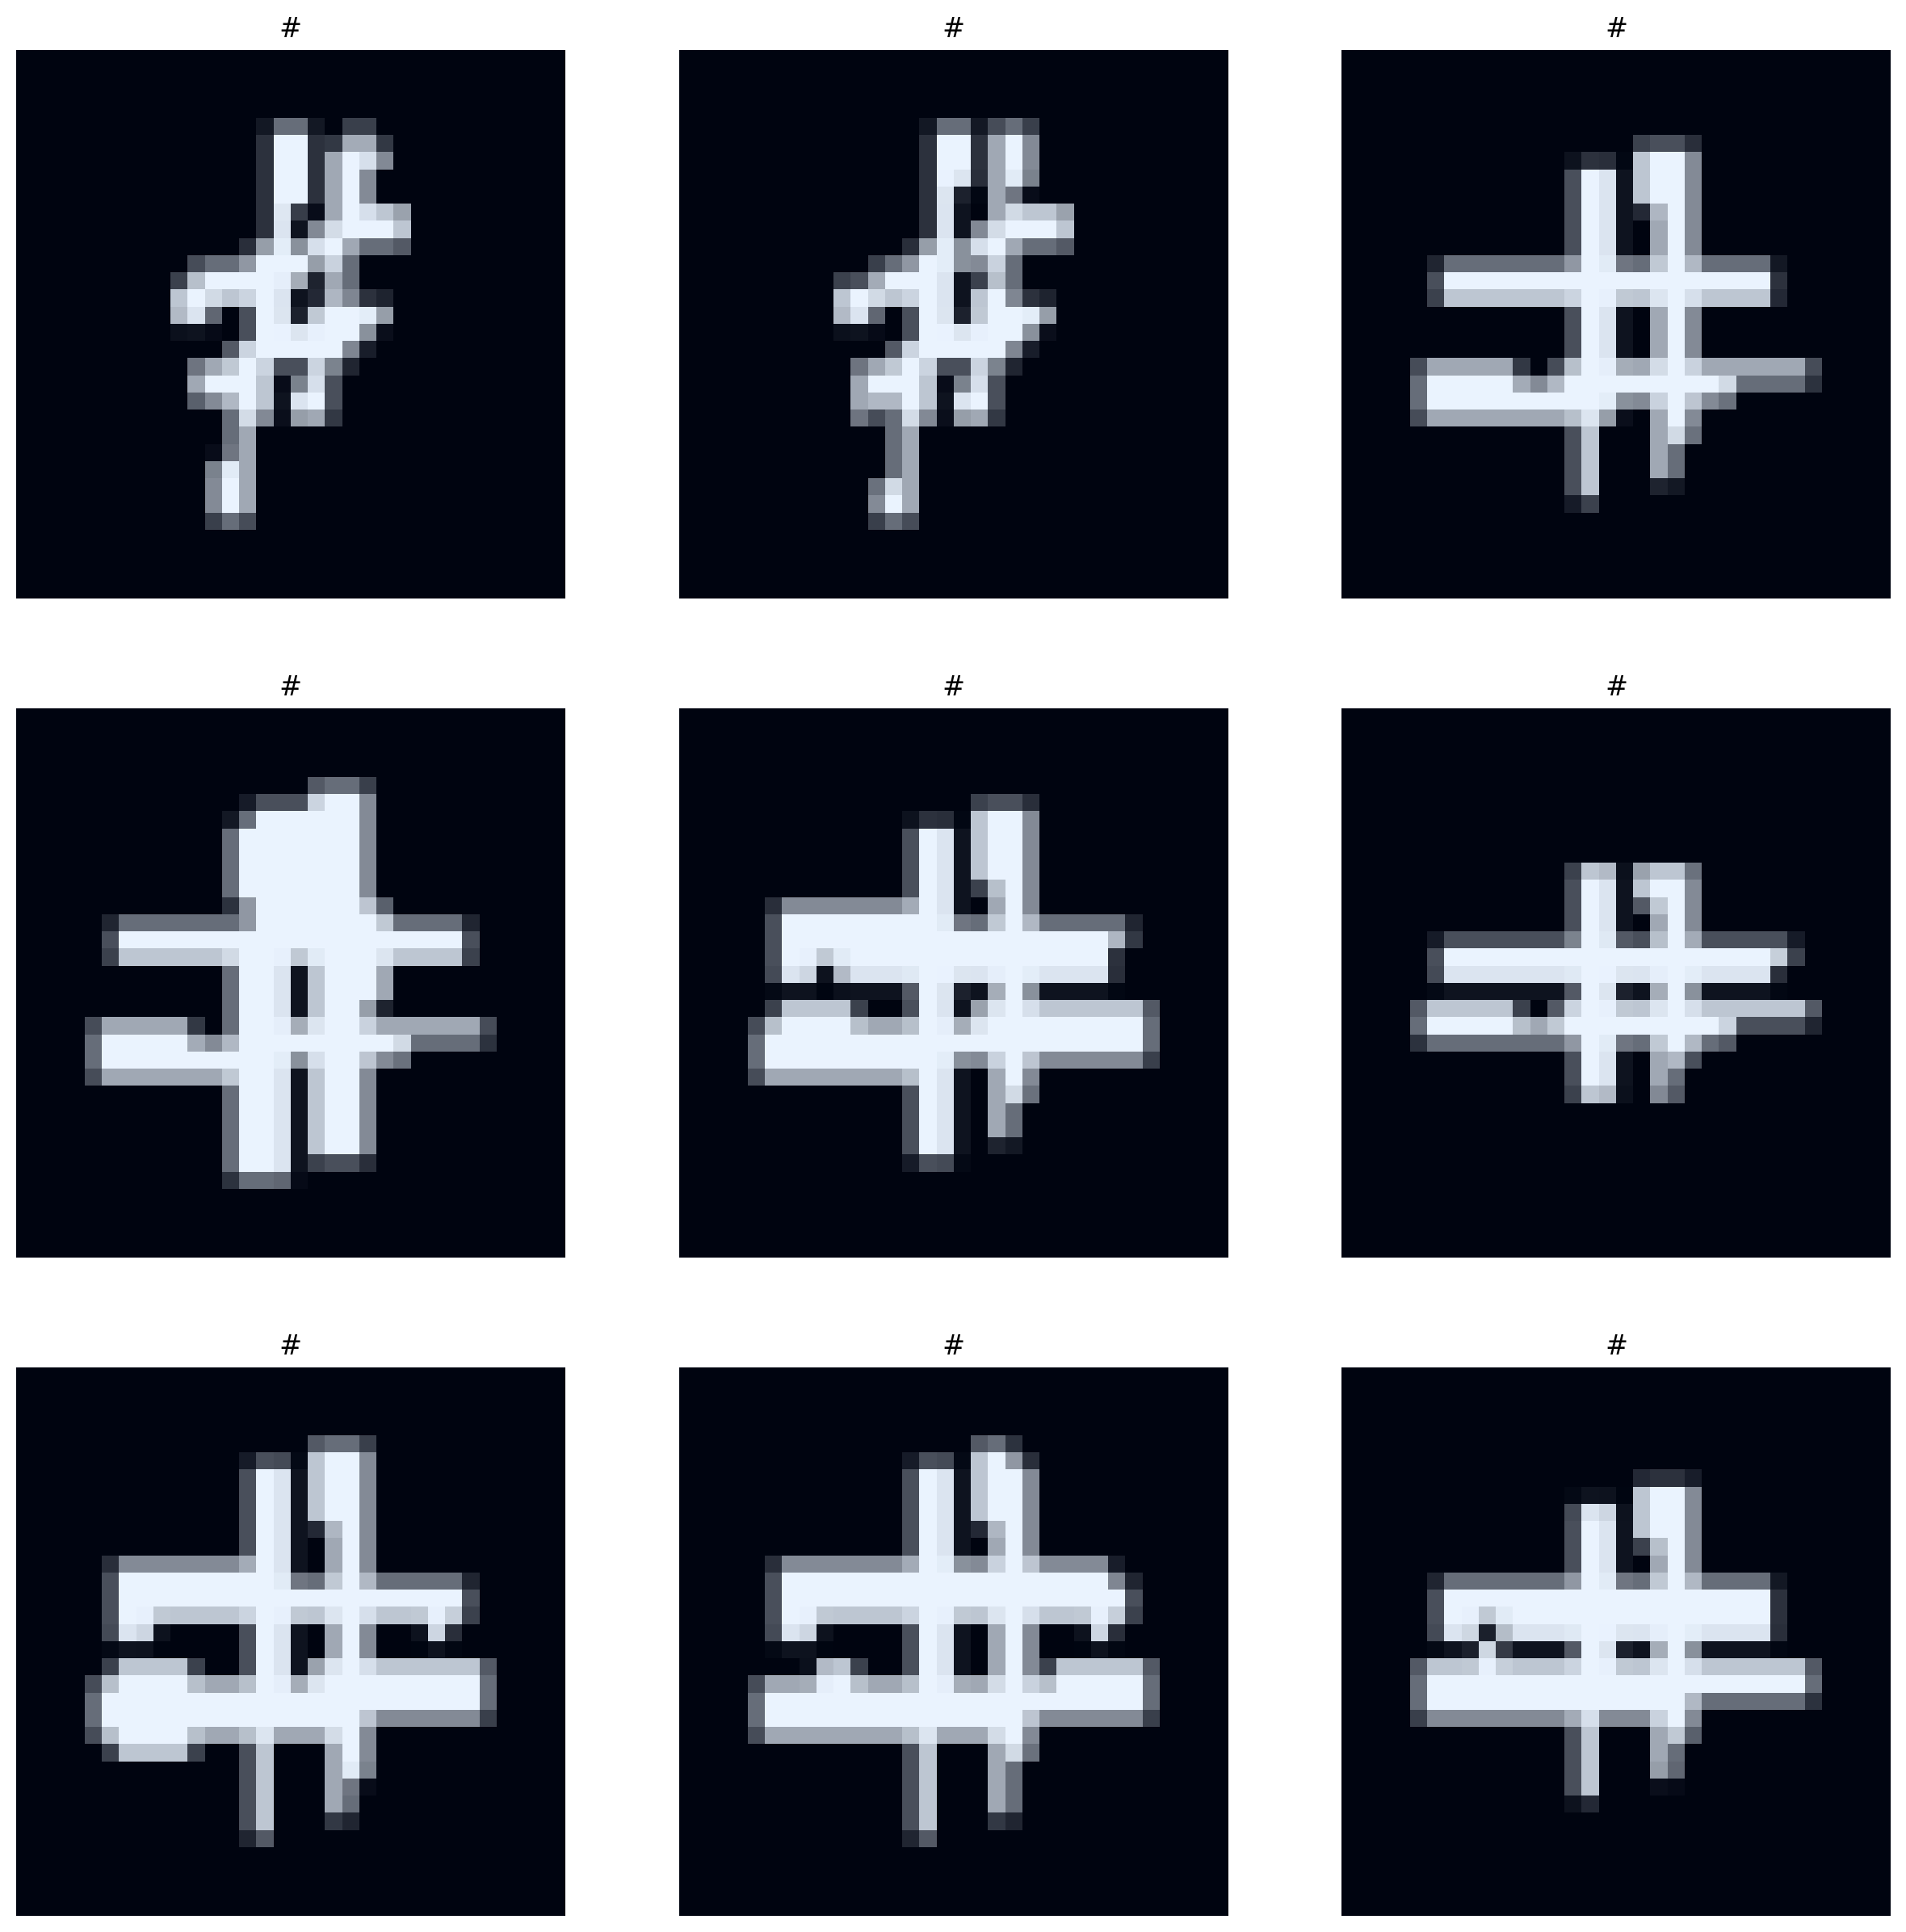

In [ ]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

Define the CNN - this example will focus on ResNet and its variation. DO NOT CHANGE THE CODE IN THESE PARTS. MIT License: Copyright (c) 2018 Ben Trevett.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

HERE you can start to define your model, you can use different resnet for your work.

In [ ]:
pretrained_model = models.resnet50(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(train_ds.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,587,943 trainable parameters


Setting the hyperparameters and train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
train_loss_resnet = []
valid_loss_resnet = []
train_acc_resnet = []
valid_acc_resnet = []

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    train_loss_resnet.append(train_loss)
    valid_loss_resnet.append(valid_loss)
    train_acc_resnet.append(train_acc_5)
    valid_acc_resnet.append(valid_acc_5)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
       # print(epoch)
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 32s
	Train Loss: 3.200 | Train Acc @1:  19.27% | Train Acc @5:  28.25%
	Valid Loss: 2.214 | Valid Acc @1:  46.70% | Valid Acc @5:  60.94%
Epoch: 02 | Epoch Time: 2m 32s
	Train Loss: 1.386 | Train Acc @1:  62.37% | Train Acc @5:  77.22%
	Valid Loss: 1.077 | Valid Acc @1:  68.14% | Valid Acc @5:  83.07%
Epoch: 03 | Epoch Time: 2m 33s
	Train Loss: 0.981 | Train Acc @1:  72.96% | Train Acc @5:  86.18%
	Valid Loss: 0.984 | Valid Acc @1:  74.39% | Valid Acc @5:  86.37%
Epoch: 04 | Epoch Time: 2m 28s
	Train Loss: 0.661 | Train Acc @1:  81.12% | Train Acc @5:  91.63%
	Valid Loss: 0.671 | Valid Acc @1:  81.25% | Valid Acc @5:  91.49%
Epoch: 05 | Epoch Time: 2m 31s
	Train Loss: 0.421 | Train Acc @1:  87.19% | Train Acc @5:  95.27%
	Valid Loss: 0.570 | Valid Acc @1:  84.03% | Valid Acc @5:  93.23%
Epoch: 06 | Epoch Time: 2m 32s
	Train Loss: 0.278 | Train Acc @1:  90.75% | Train Acc @5:  97.42%
	Valid Loss: 0.578 | Valid Acc @1:  84.72% | Valid Acc @5:  93.49%
Epoch: 07 

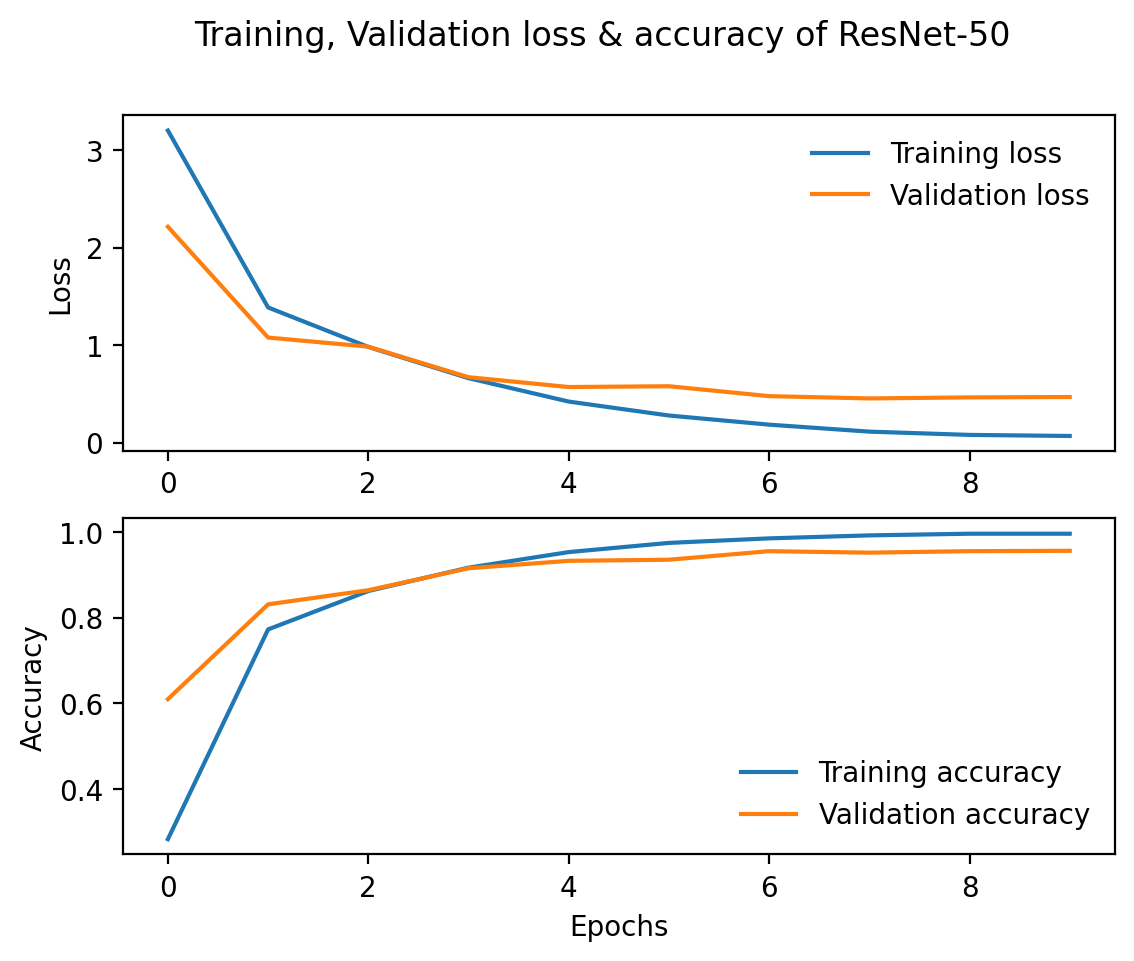

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training, Validation loss & accuracy of ResNet-50')
ax1.plot(train_loss_resnet, label='Training loss')
ax1.plot(valid_loss_resnet, label='Validation loss')
# ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)

ax2.plot(train_acc_resnet, label='Training accuracy')
ax2.plot(valid_acc_resnet, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

### Loading the best model

In [ ]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter)

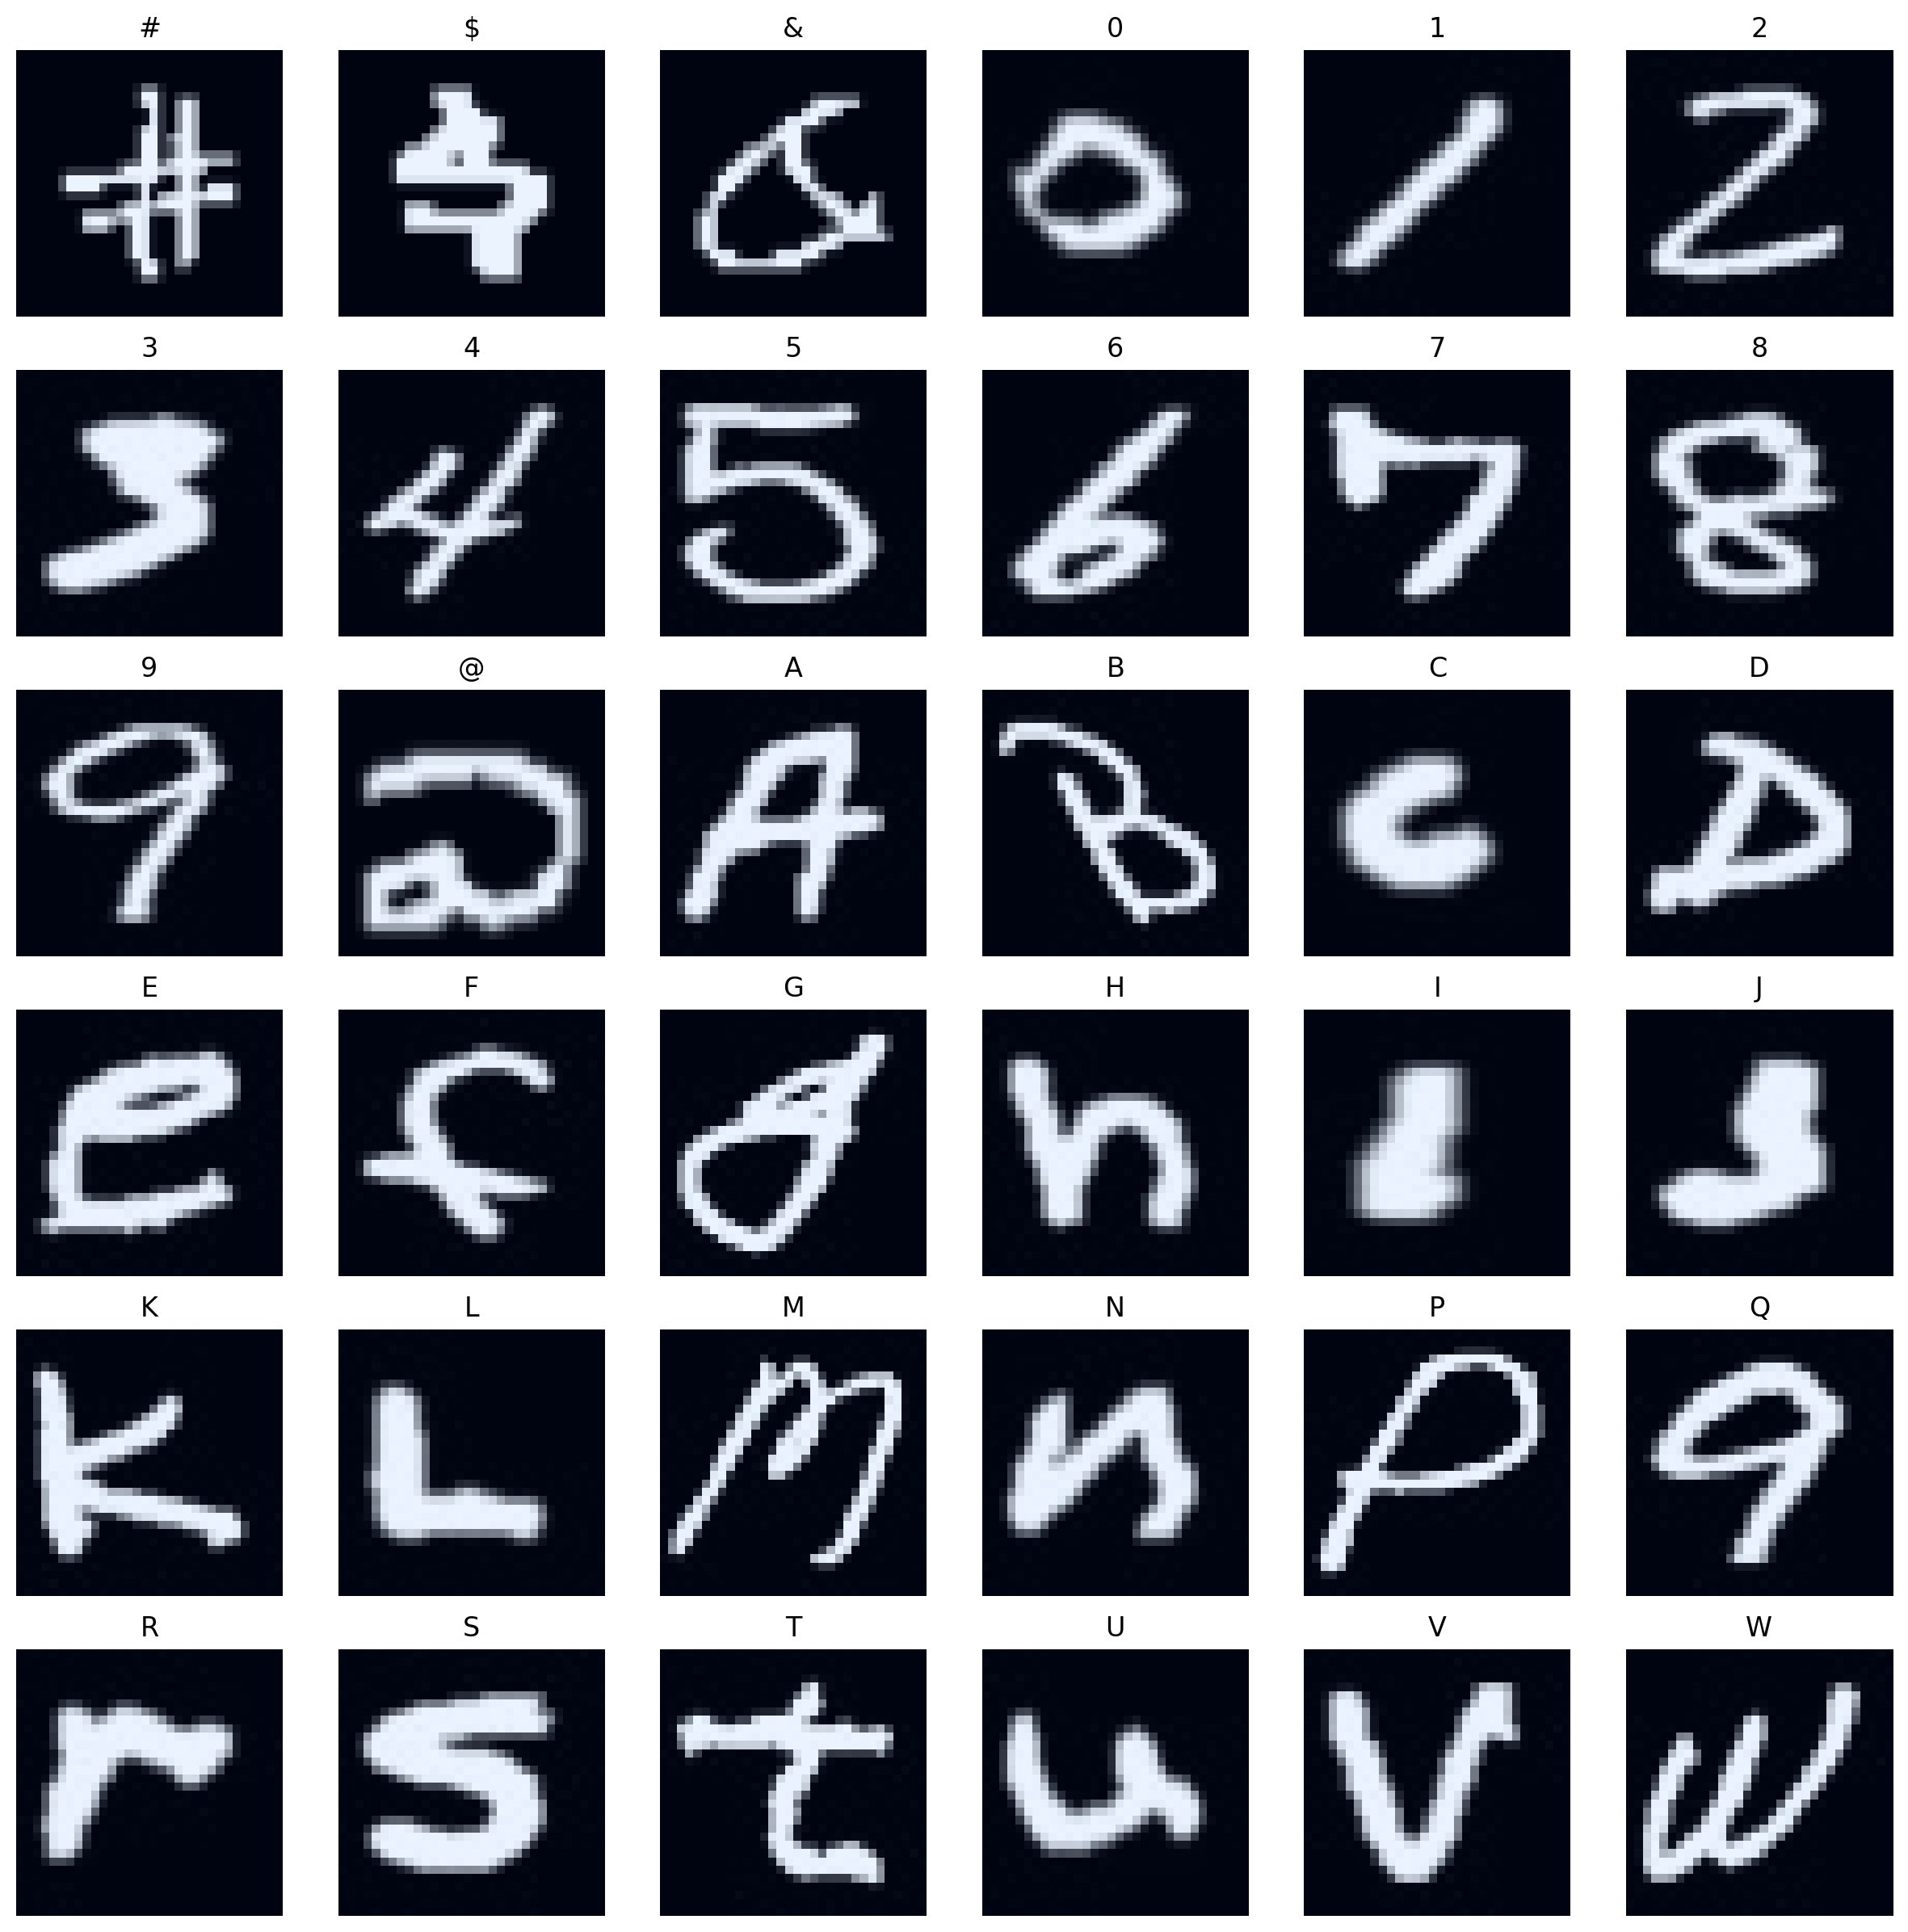

In [ ]:
plot_images(images, labels, classes)

### Implementing Alexnet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

HERE you can adjust the number of classes

In [ ]:
OUTPUT_DIM = 39

model = AlexNet(OUTPUT_DIM)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

This is to display the number of trainable parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,391,079 trainable parameters


Setting the hyperparameters and train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=CHOSE_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs



In [ ]:
EPOCHS = 10 # You may need to run longer to get better results. Lab example is for demo only

# keeping-track-of-losses
train_loss_alex = []
valid_losses_alex = []
train_accus_alex = []
valid_accus_alex = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    train_loss_alex.append(train_loss)
    valid_losses_alex.append(valid_loss)
    train_accus_alex.append(train_acc)
    valid_accus_alex.append(valid_acc)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 32s
	Train Loss: 4.465 | Train Acc: 3.05%
	 Val. Loss: 3.538 |  Val. Acc: 6.51%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 27s
	Train Loss: 3.252 | Train Acc: 10.59%
	 Val. Loss: 2.670 |  Val. Acc: 23.00%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 31s
	Train Loss: 2.178 | Train Acc: 34.61%
	 Val. Loss: 1.685 |  Val. Acc: 51.65%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 28s
	Train Loss: 1.465 | Train Acc: 54.34%
	 Val. Loss: 1.284 |  Val. Acc: 59.20%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 30s
	Train Loss: 1.054 | Train Acc: 66.43%
	 Val. Loss: 1.148 |  Val. Acc: 66.75%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 29s
	Train Loss: 0.865 | Train Acc: 72.34%
	 Val. Loss: 0.934 |  Val. Acc: 72.40%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 41s
	Train Loss: 0.700 | Train Acc: 77.09%
	 Val. Loss: 0.794 |  Val. Acc: 75.26%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 37s
	Train Loss: 0.640 | Train Acc: 78.69%
	 Val. Loss: 0.900 |  Val. Acc: 75.52%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 41s
	Train Loss: 0.544 | Train Acc: 82.33%
	 Val. Loss: 0.769 |  Val. Acc: 80.12%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 40s
	Train Loss: 0.502 | Train Acc: 84.40%
	 Val. Loss: 0.741 |  Val. Acc: 80.99%


Example code to plot losses.

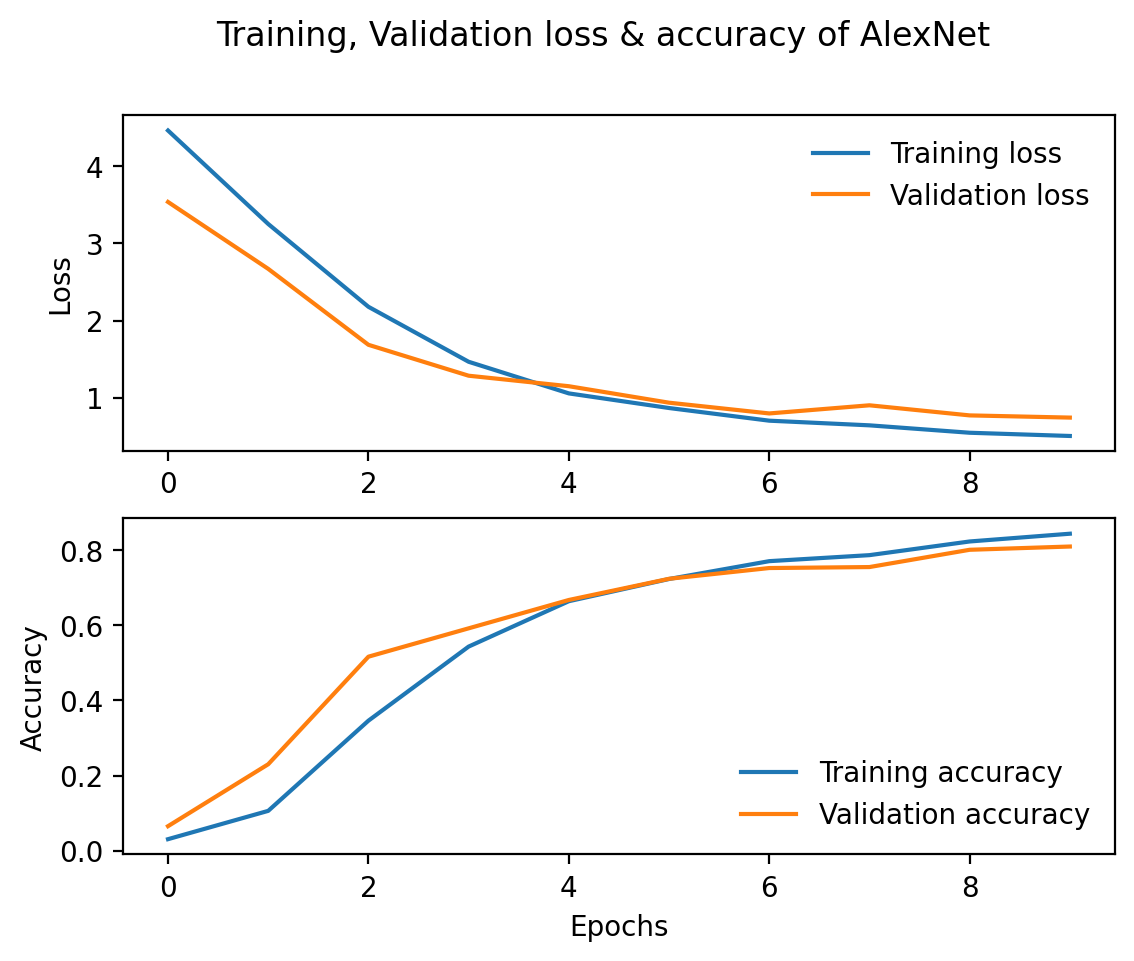

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training, Validation loss & accuracy of AlexNet')
ax1.plot(train_loss_alex, label='Training loss')
ax1.plot(valid_losses_alex, label='Validation loss')
# ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)

ax2.plot(train_accus_alex, label='Training accuracy')
ax2.plot(valid_accus_alex, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)

### Loading the best model

In [ ]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter, device)

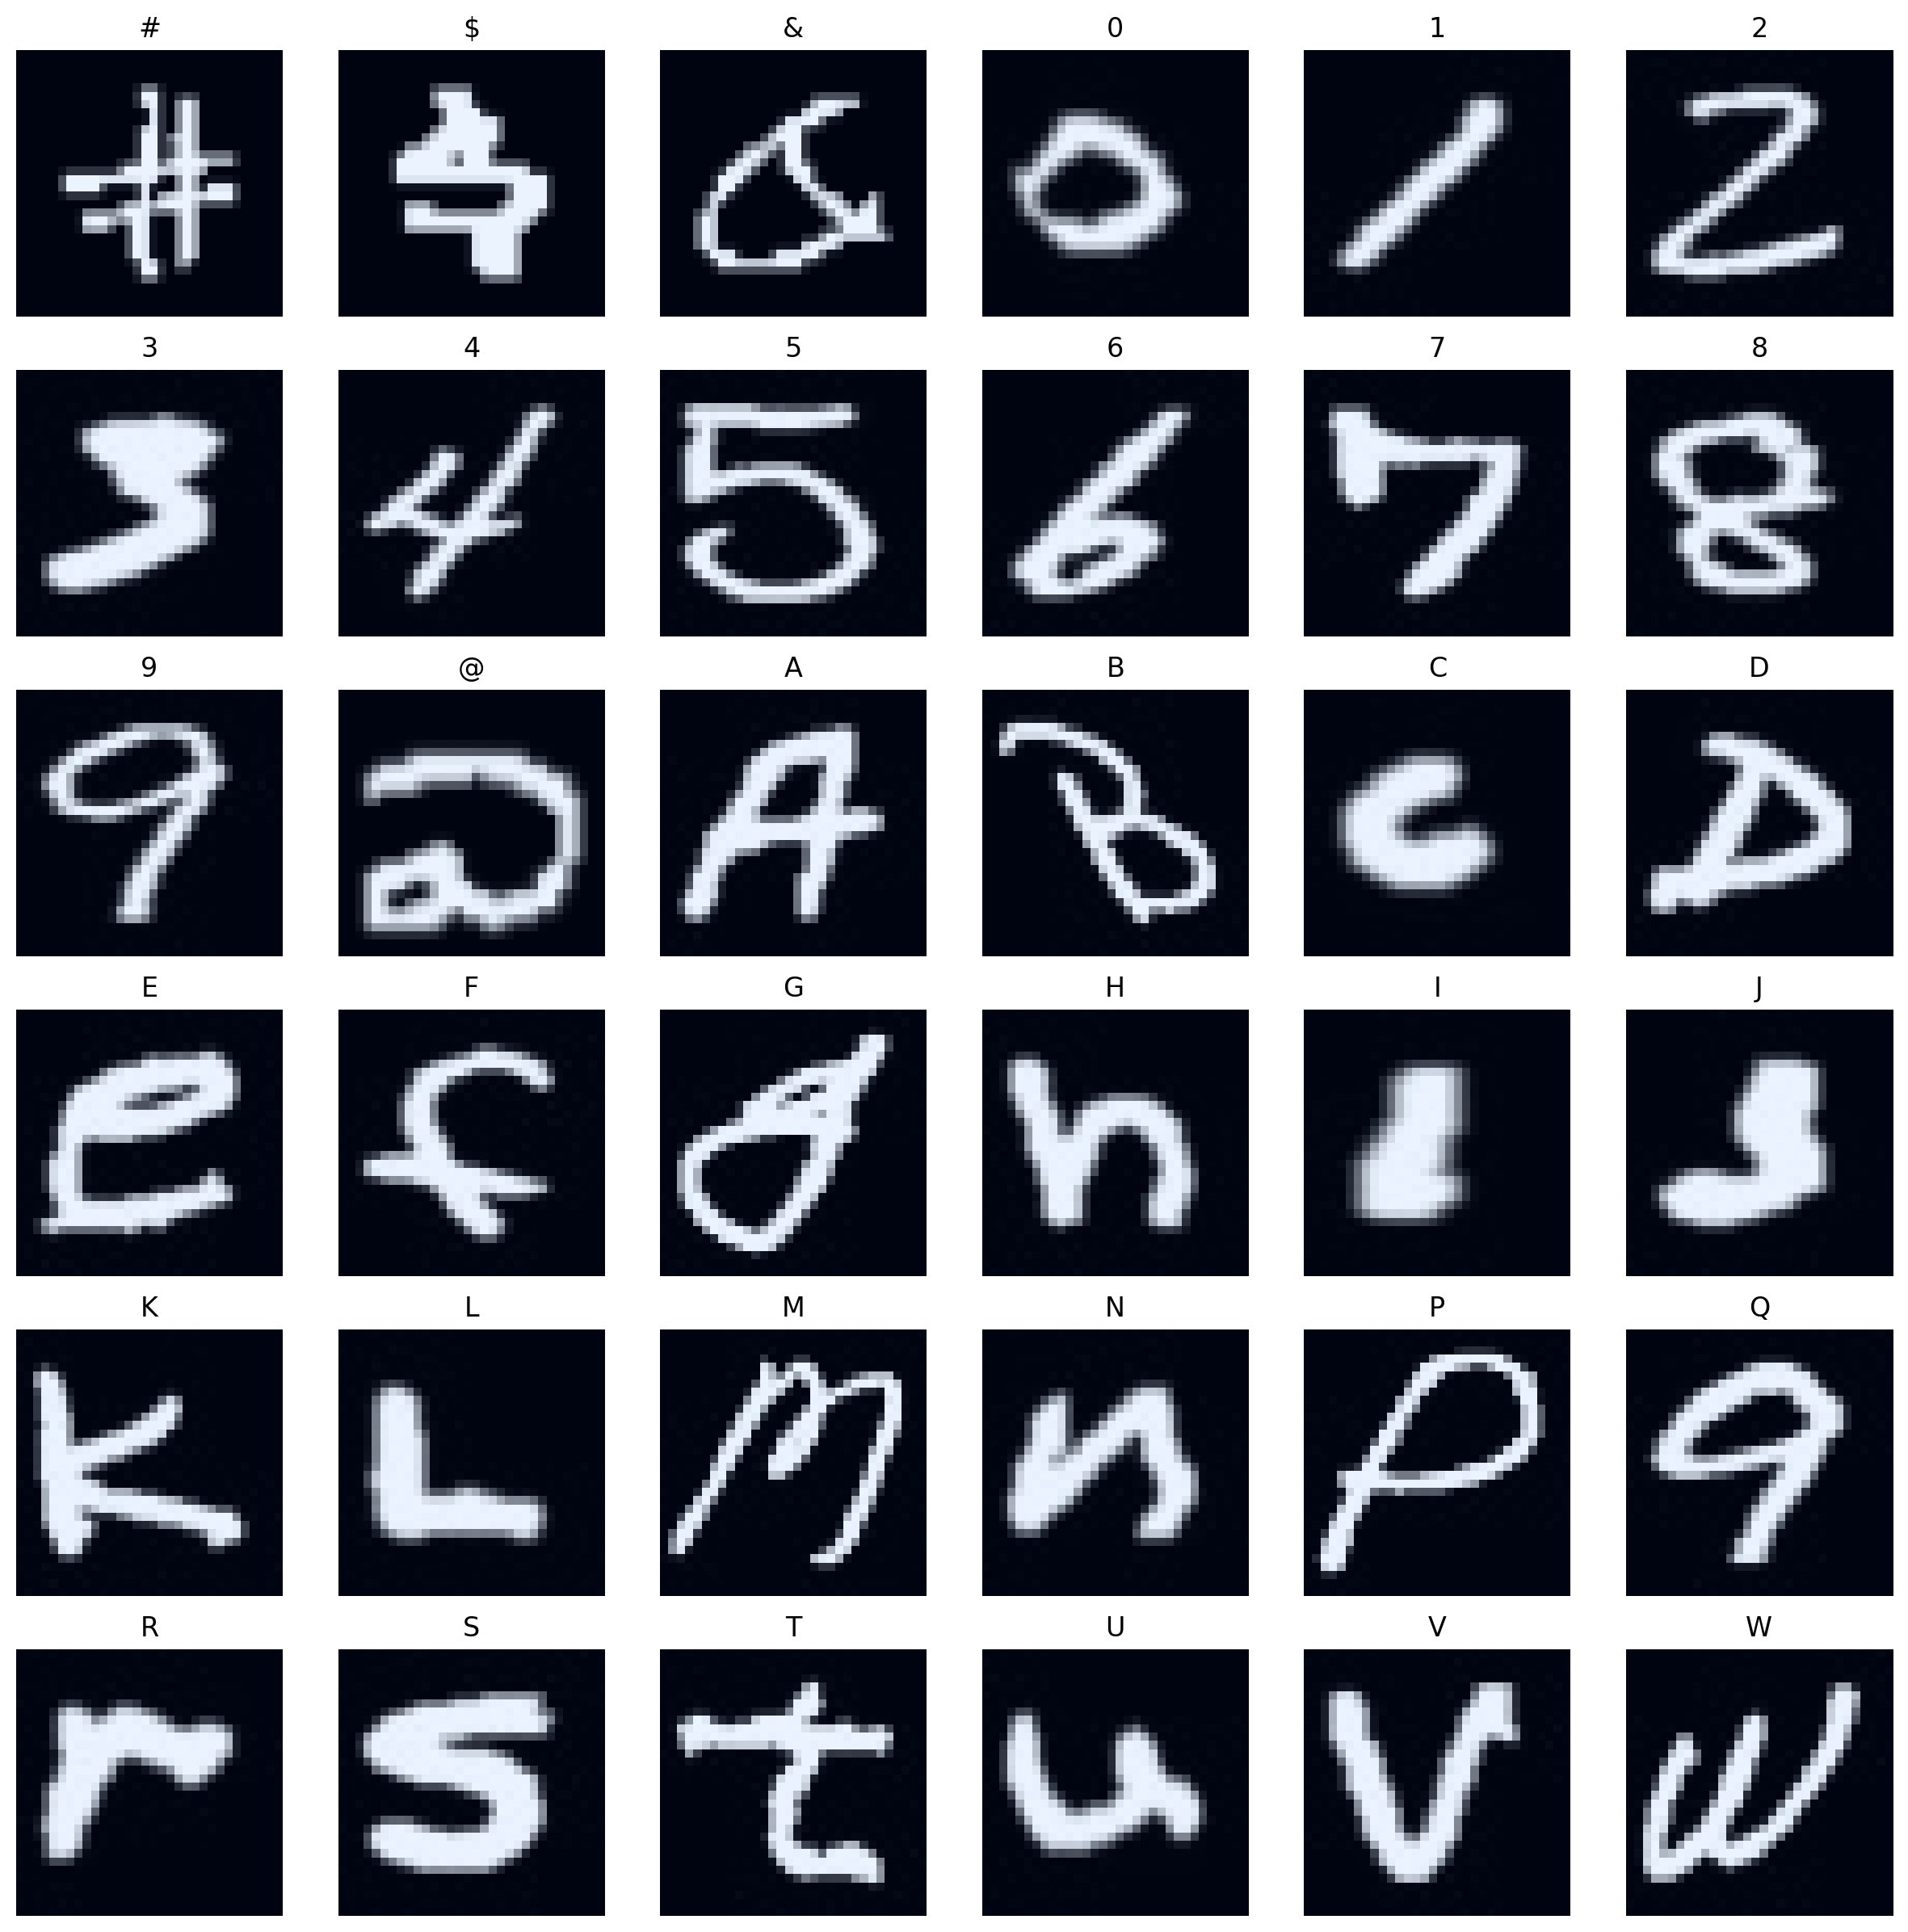

In [ ]:
plot_images(images, labels, classes)

### VGG
Define the CNN - this example will focus on VGG
 and its variation. DO NOT CHANGE THE CODE IN THESE PARTS. MIT License: Copyright (c) 2018 Ben Trevett.

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

HERE you can start to define your model, you can use different vgg for your work. Change the OUTPUT_DIM to the number of classes.

In [ ]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
#print(vgg11_layers)

OUTPUT_DIM = 39

model = VGG(vgg11_layers, OUTPUT_DIM)
#print(model)
pretrained_model = models.vgg11_bn(pretrained=True)
#print(pretrained_model)
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,931,623 trainable parameters


Setting the hyperparameters and train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
EPOCHS = 5
train_loss_vgg = []
valid_loss_vgg = []
train_acc_vgg = []
valid_acc_vgg = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    train_loss_vgg.append(train_loss)
    valid_loss_vgg.append(valid_loss)
    train_acc_vgg.append(train_acc)
    valid_acc_vgg.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 7m 26s
	Train Loss: 4.849 | Train Acc: 6.43%
	 Val. Loss: 3.092 |  Val. Acc: 13.11%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 7m 27s
	Train Loss: 3.147 | Train Acc: 11.67%
	 Val. Loss: 2.601 |  Val. Acc: 24.13%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 7m 32s
	Train Loss: 2.940 | Train Acc: 14.46%
	 Val. Loss: 2.458 |  Val. Acc: 26.82%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 7m 27s
	Train Loss: 2.782 | Train Acc: 16.63%
	 Val. Loss: 2.417 |  Val. Acc: 27.43%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 7m 29s
	Train Loss: 2.726 | Train Acc: 17.36%
	 Val. Loss: 2.159 |  Val. Acc: 34.29%


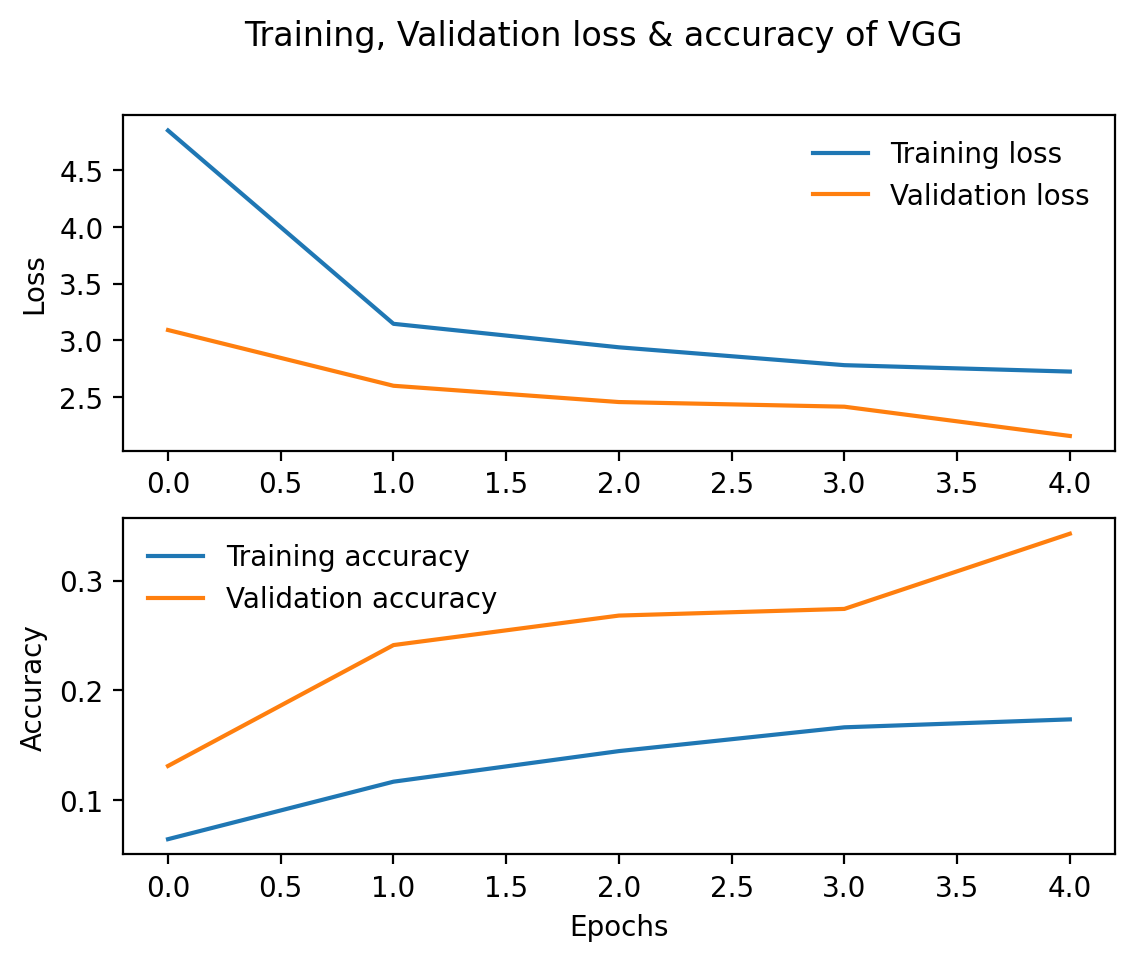

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training, Validation loss & accuracy of VGG')
ax1.plot(train_loss_vgg, label='Training loss')
ax1.plot(valid_loss_vgg, label='Validation loss')
# ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)

ax2.plot(train_acc_vgg, label='Training accuracy')
ax2.plot(valid_acc_vgg, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)

### Loading the best model

In [ ]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter)

  0%|          | 0/2 [00:00<?, ?it/s]

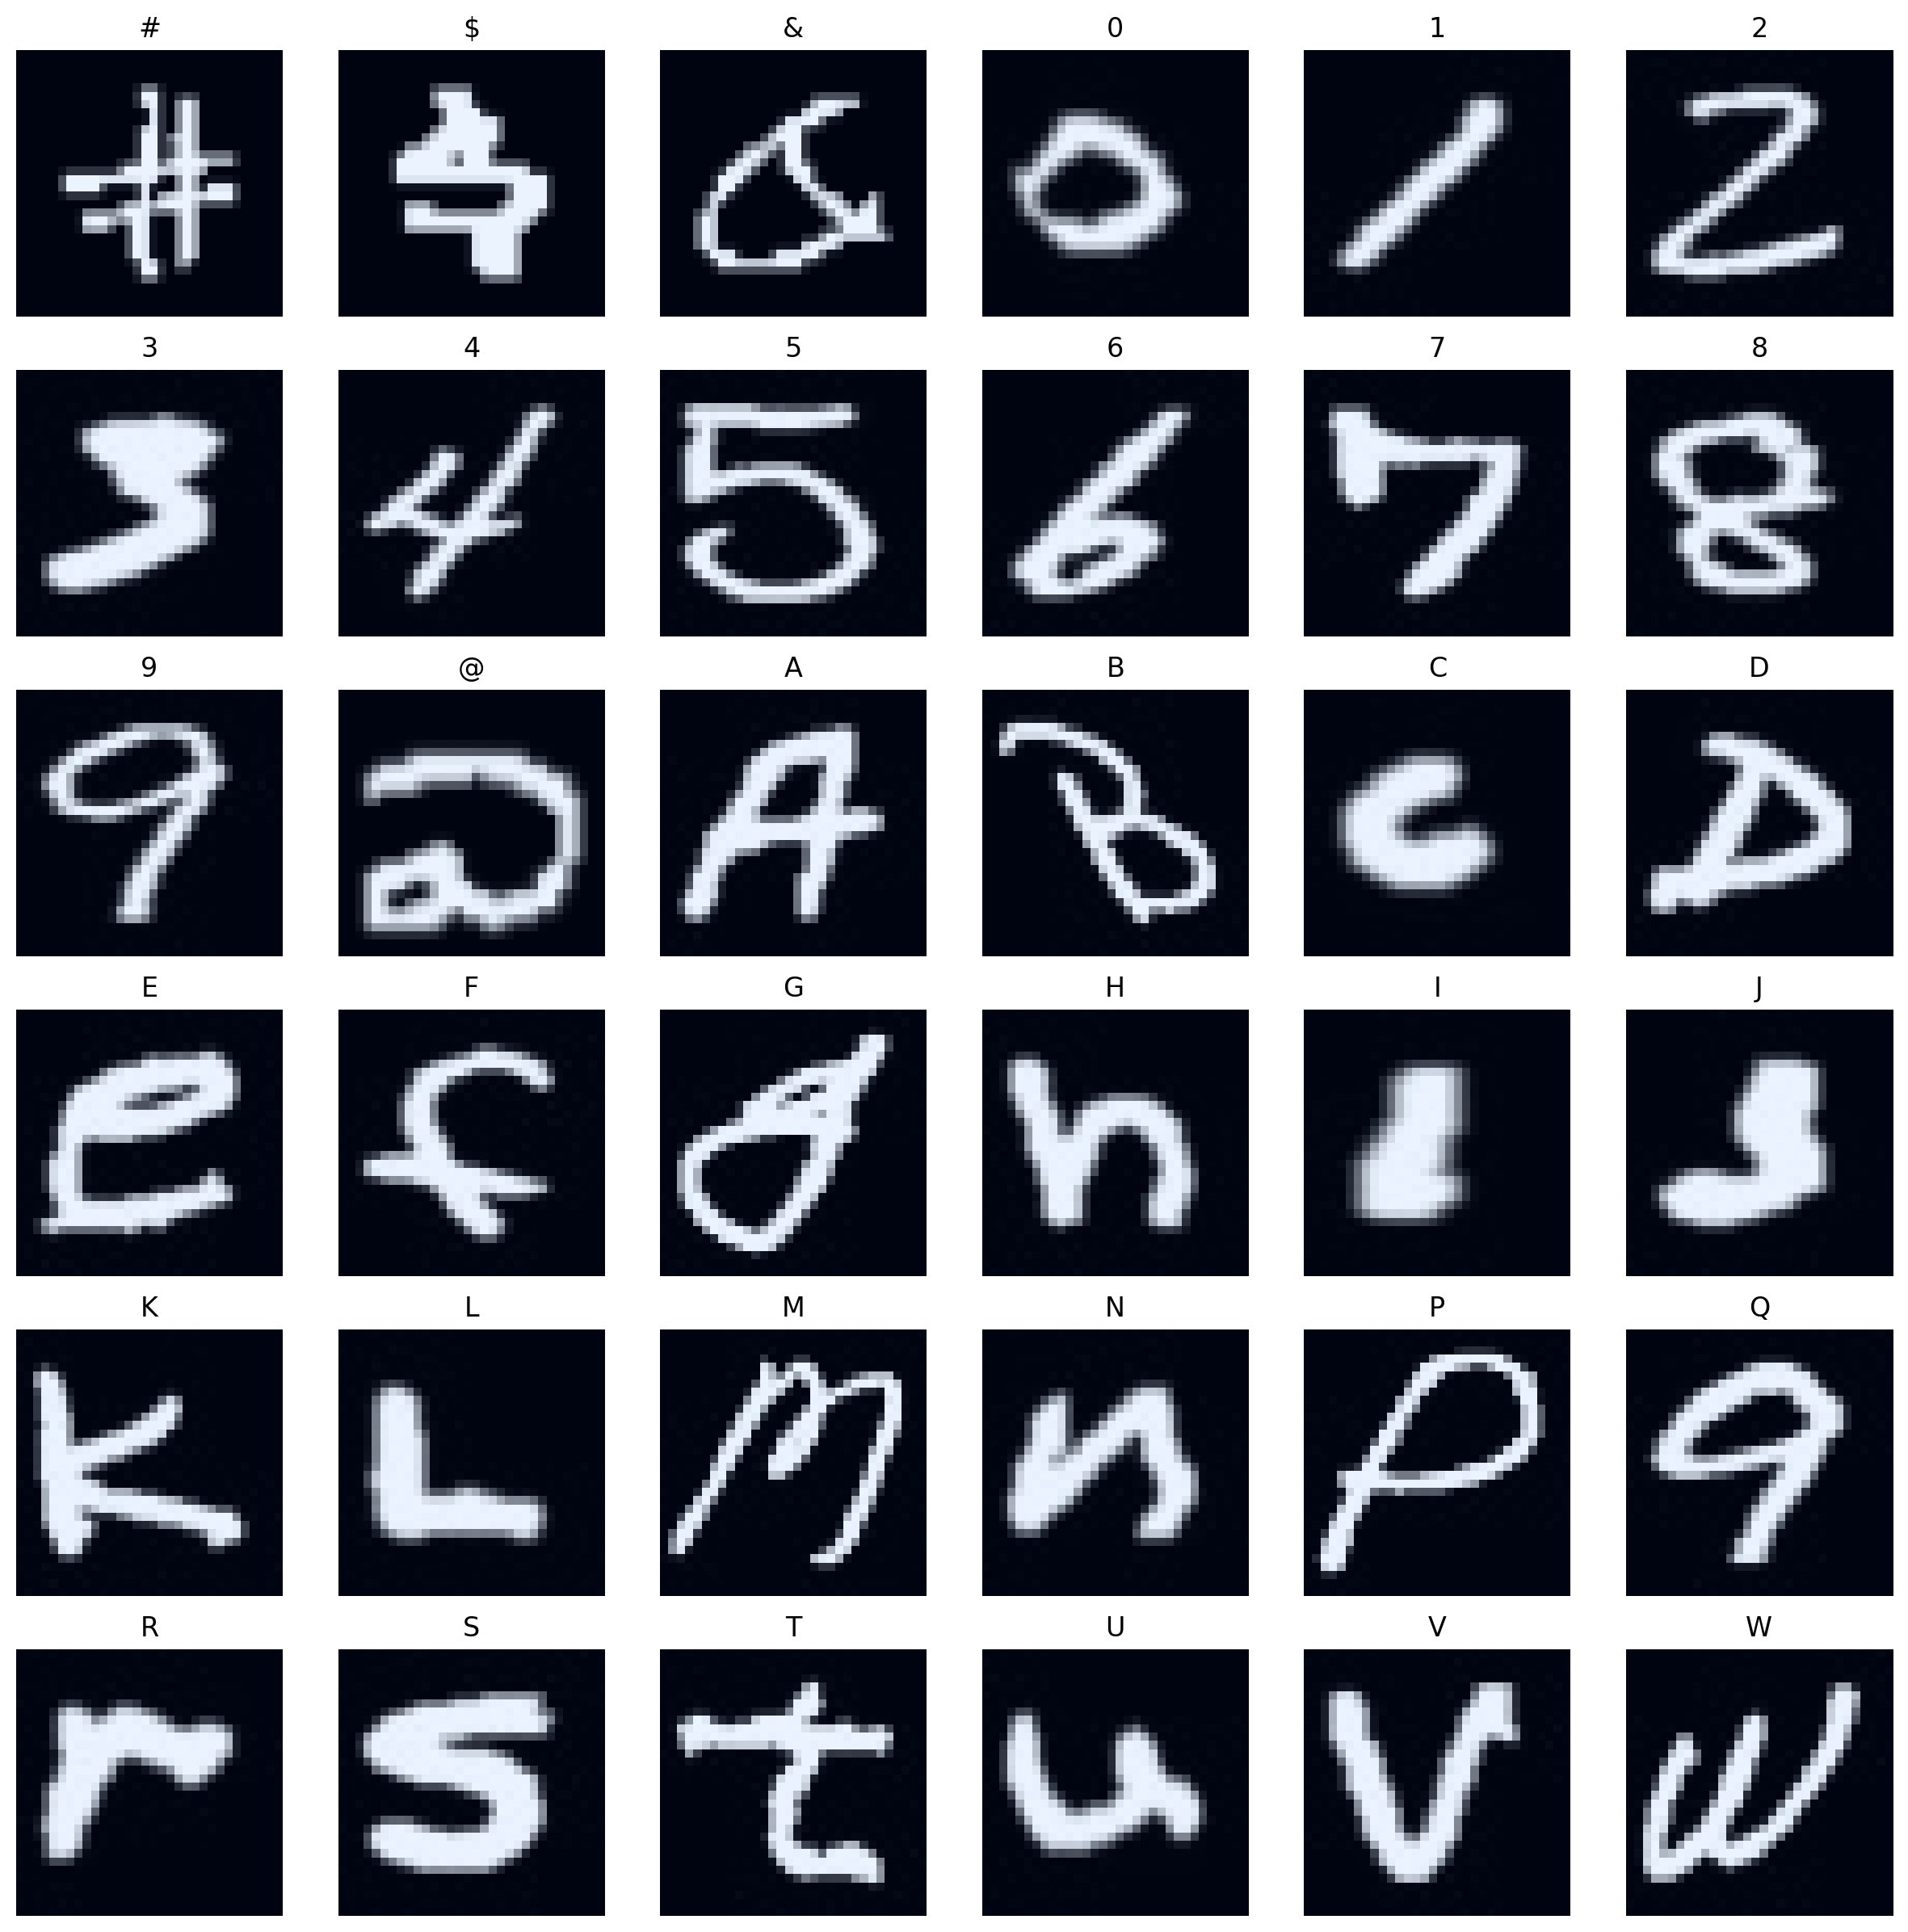

In [ ]:
plot_images(images, labels, classes)